Code for examining how HMM performs under repeated recalibration


In [75]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

import sys, glob
[sys.path.append(f) for f in glob.glob('../utils/*')]
from plotting_utils import figSize
from hmm import HMMRecalibration
import hmm_utils
import simulation_utils 
from simulation import simulateBCIFitts
from stabilizer_utils import *

# for a reproducible result
np.random.seed(1)

fig_path    = '/home/users/ghwilson/projects/nonstationarities/figures/'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Define an initial decoder and initial neural tuning properties (mean firing rates and preferred directions).


In [76]:
'''The first column of initialTuning is the means, and the second two columns are the preferred directions. 
We make sure that the last two columns are orthogonal (uniformly distributed PDs) 
and that the tuning strength is set to SNR (norm of the column is SNR). '''

nUnits         = 192
SNR            = 0.5
nTrainingSteps = 10000

initialTuning          = simulation_utils.generateUnits(n_units = nUnits, SNR = SNR)
calNeural, calVelocity = simulation_utils.simulateUnitActivity(initialTuning, noise = 0.3, nSteps= nTrainingSteps)
lr                     = LinearRegression(fit_intercept = True).fit(calNeural, calVelocity)
D                      = np.hstack([lr.intercept_[:, np.newaxis], lr.coef_]).T

# Normalize the gain of this decoder so that it will output vectors with a magnitude of 1 when the encoded velocity has a magnitude of 1. 
D[:, 0] = D[:,0] / np.linalg.norm(D[1:, :][:, 0]) / np.linalg.norm(initialTuning[:, 1])
D[:, 1] = D[:,1] / np.linalg.norm(D[1:, :][:, 1]) / np.linalg.norm(initialTuning[:, 2])

In [77]:
cfg = dict()
cfg['neuralTuning'] = initialTuning
cfg['D']            = D
cfg['alpha']        = 0.94 # amount of exponential smoothing (0.9 to 0.96 are reasonable)
cfg['delT']         = 0.02 # define the time step (20 ms)
cfg['nDelaySteps']  = 10   # define the simulated user's visual feedback delay (200 ms)
cfg['nSimSteps']    = 10000

possibleGain = np.linspace(0.1,2.5,10)
cfg['beta']  = simulation_utils.gainSweep(cfg, possibleGain, verbose = True)

print('Using gain value beta = ', cfg['beta'])

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
Using gain value beta =  0.6333333333333333


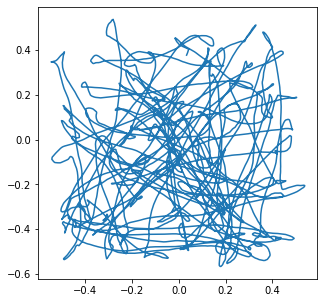

In [86]:
figSize(5, 5)

results = simulateBCIFitts(cfg)

plt.plot(results['posTraj'][:, 0], results['posTraj'][:, 1])
plt.show()

In [91]:
def simulate_MultiSessionHMM(cfg, hmm, n_sessions, days_between, shrinkage):
    
    session_scores = np.zeros((n_sessions + 1, 3))
    
    # Day 0 performance:
    D_HMM     = np.copy(cfg['D'])
    D_super   = np.copy(cfg['D'])
    tuning    = np.copy(cfg['neuralTuning'])
    
    norecal_cfg  = copy.deepcopy(cfg)
    super_cfg    = copy.deepcopy(cfg)
    hmmrep_cfg   = copy.deepcopy(cfg)
    
    ttt     = simulateBCIFitts(cfg)['ttt']
    session_scores[0, :] = np.mean(ttt)
    
    for i in range(n_sessions):
        for j in range(days_between + 1):
            # introduce daily nonstationarities between recorded sessions
            tuning = simulation_utils.simulateTuningShift(tuning, PD_shrinkage = shrinkage, 
                                                          mean_shift = 0, renormalize = simulation_utils.sampleSNR())  
        norecal_cfg['neuralTuning'] = tuning
        super_cfg['neuralTuning']   = tuning
        hmmrep_cfg['neuralTuning']  = tuning
        
        # No recalibration:
        norecal_cfg['D'][:, 0] = norecal_cfg['D'][:,0] / np.linalg.norm(norecal_cfg['D'][1:, :][:, 0]) / np.linalg.norm(tuning[:, 1])
        norecal_cfg['D'][:, 1] = norecal_cfg['D'][:,1] / np.linalg.norm(norecal_cfg['D'][1:, :][:, 1]) / np.linalg.norm(tuning[:, 2])        
        session_scores[i+1, 0] = np.mean(simulateBCIFitts(norecal_cfg)['ttt'])
        
        # supervised: 
        super_cfg['D'] = simulation_utils.simulate_OpenLoopRecalibration(super_cfg, nSteps = 10000)
        super_cfg['D'] = simulation_utils.simulate_ClosedLoopRecalibration(super_cfg)
        session_scores[i+1, 1] = np.mean(simulateBCIFitts(super_cfg)['ttt'])

        # HMM recalibration (repeated):   
        #if np.isnan(D_HMM).any():
        #    return hmmrep_cfg, targLocs
        hmmrep_cfg['D']        = simulation_utils.simulate_HMMRecalibration(hmmrep_cfg, hmm)
        session_scores[i+1, 2] = np.mean(simulateBCIFitts(hmmrep_cfg)['ttt'])

    return session_scores
    

In [92]:
import copy
from joblib import Parallel, delayed

np.random.seed(42)

# general settings:
n_sessions   = 30     # number of sessions to simulate 
days_between = 0      # days between session days
reps         = 10     # how many times to repeat the repeated nonstationarities simulation
nSimSteps    = 10000  # number of timesteps for simulating session usage 
shrinkage    = 0.9    # relative tuning in subspace per new day

# HMM settings:
vmKappa    = 2          # Precision parameter for the von mises distribution
probThresh = 0.4        # todo: implement
gridSize   = 20
stayProb   = 0.9999
adjustKappa = lambda x: 1 / (1 + np.exp(-1 * (x - 0.15) * 5))


#-----------------------------------------
session_scores          = np.zeros((reps, n_sessions + 1, 3)) # 0: no recalibration, 1: HMM recalibration (just once), 2: repeated HMM recalibration
nStates                 = gridSize**2
targLocs                = hmm_utils.generateTargetGrid(gridSize = gridSize)
stateTrans, pStateStart = hmm_utils.generateTransitionMatrix(gridSize = gridSize, stayProb = stayProb)

hmm = HMMRecalibration(stateTrans, targLocs, pStateStart, vmKappa, adjustKappa = adjustKappa)

args           = [[cfg, hmm, n_sessions, days_between, shrinkage]] * reps
rep_data       = Parallel(n_jobs= -1, verbose = 11)(delayed(simulate_MultiSessionHMM)(*x) for x in args)
session_scores = np.dstack(rep_data).swapaxes(2, 0).swapaxes(1, 2)
    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:  3.2min remaining: 12.7min
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  3.2min remaining:  7.5min
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:  3.2min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  3.2min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  3.2min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  3.2min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:  3.3min remaining:   48.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.3min finished


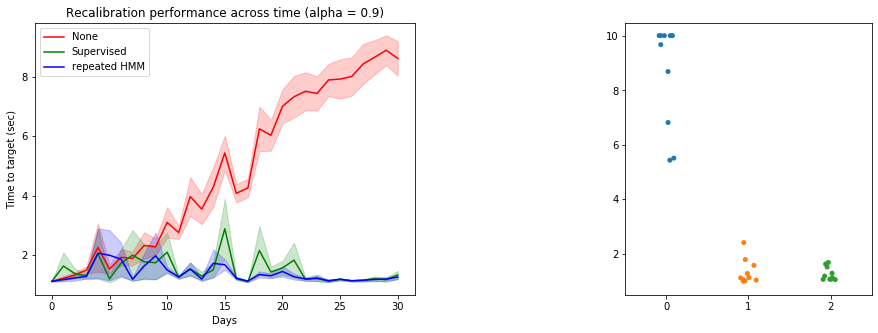

In [93]:
figSize(5, 15)
from lineplots import plotsd
import seaborn as sns 


labels = ['None', 'Supervised', 'repeated HMM']
colors = ['r', 'g', 'b']
days   = np.linspace(0, (days_between + 1) * n_sessions, n_sessions + 1)

plt.subplot(1, 2, 1)
for i, label in enumerate(labels):
    plotsd(data = session_scores[:, :, i], time_bins = days, color = colors[i], toggleSE = True)

plt.legend(labels, loc = 'upper left')
plt.title('Recalibration performance across time (alpha = ' + str(shrinkage) + ')')
plt.xlabel('Days')
plt.ylabel('Time to target (sec)')

plt.subplot(1, 3, 3)
colors   = ['r', 'g', 'b']
plt_data = [session_scores[:, -1, i].flatten() for i in range(3)]
sns.stripplot(data = plt_data)

#plt.savefig(fig_path + 'simulator/repeated_HMMrecal', format = 'pdf')
plt.show()


In [94]:
import scipy

print('None and supervised:, ', scipy.stats.ranksums(plt_data[0], plt_data[1]))
print('None and HMM:, ', scipy.stats.ranksums(plt_data[0], plt_data[2]))
print('supervised and HMM:, ', scipy.stats.ranksums(plt_data[1], plt_data[2]))

None and supervised:,  RanksumsResult(statistic=3.779644730092272, pvalue=0.00015705228423075119)
None and HMM:,  RanksumsResult(statistic=3.779644730092272, pvalue=0.00015705228423075119)
supervised and HMM:,  RanksumsResult(statistic=-0.5291502622129182, pvalue=0.5967012167293563)
